In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import networkx as nx
import torch_geometric as pyg

import LPGNN

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-13 20:12:58.853908: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 20:12:58.853930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.tree_pruning)
importlib.reload(LPGNN.LinkPrediction)

<module 'LPGNN.LinkPrediction' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/LinkPrediction.py'>

## Load ASI network

In [3]:
ASI = th.Tensor(np.loadtxt('Network_Files/ASI_t0.txt')).T.type(th.int64)
ASI = ASI-1 # Convert to 0-indexing
ASI = pyg.utils.to_undirected(ASI)
ASI = pyg.data.Data(edge_index=ASI)
ASI.num_nodes = ASI.num_nodes

# Second snapshot, which we consider to be the test set.
ASI_test = th.Tensor(np.loadtxt('Network_Files/ASI_t1.txt')).T.type(th.int64)
ASI_test = ASI_test-1

# remove edges in test set which are also in training set
ASI_test_temp = th.Tensor([[-1,-1]])
for edge in ASI_test.T:
    if len(th.where((edge == ASI.edge_index.T).all(dim=1))[0]) == 0:
        ASI_test_temp = th.cat((ASI_test_temp, edge.view(1,2)), dim=0)
ASI_test = ASI_test_temp[1:].T.long()
ASI.test_pos_edge_label_index = ASI_test

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [4]:
# print ASI number of nodes, number of edges in training set, number of edges in test set, with nice formatting in three lines
print('N° of nodes:       {:,}'.format(ASI.num_nodes))
print('N° of train edges: {:,}'.format(ASI.edge_index.shape[1]/2))
print('N° of test edges:  {:,}'.format(ASI.test_pos_edge_label_index.shape[1]))

N° of nodes:       24,091
N° of train edges: 59,531.0
N° of test edges:  48,119


### Generate LaBNE ASI network. Then, get precision and recall curve by calculating the distance matrix between all nodes.

In [7]:
ASI_LaBNE = LPGNN.labne.generateLaBNE(ASI, edge_index='edge_index', normalize_radius=0.9)
ASI_R_LaBNE_poincare, ASI_P_LaBNE_poincare = LPGNN.LinkPrediction.precision_recall_score_file(ASI_LaBNE, position_name='LaBNE_node_positions', filename='data/Distance_Lists/ASI/ASI_LaBNE', chunk_size=200000, skip_file_prep=False, step_size=10000, dist='poincare')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE_sorted')
ASI_R_LaBNE_hyp_norm, ASI_P_LaBNE_hyp_norm = LPGNN.LinkPrediction.precision_recall_score_file(ASI_LaBNE, position_name='LaBNE_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_LaBNE', chunk_size=200000, skip_file_prep=False, step_size=10000, dist='hyp')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE_sorted')
ASI_LaBNE = LPGNN.labne.generateLaBNE(ASI, edge_index='edge_index', normalize_radius=False)
ASI_R_LaBNE_hyp_nonorm, ASI_P_LaBNE_hyp_nonorm = LPGNN.LinkPrediction.precision_recall_score_file(ASI_LaBNE, position_name='LaBNE_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_LaBNE', chunk_size=200000, skip_file_prep=False, step_size=10000, dist='hyp')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE_sorted')

Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 289280000, R: 1.000, P: 0.000Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 289950000, R: 1.000, P: 0.000Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

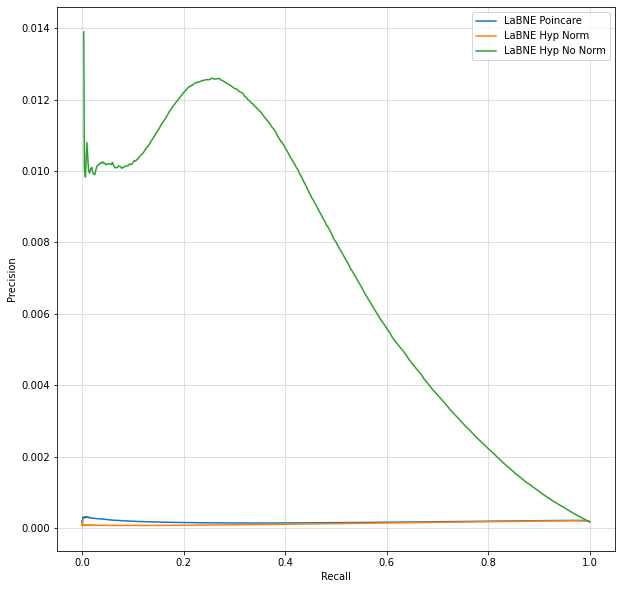

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(ASI_R_LaBNE_poincare, ASI_P_LaBNE_poincare, label='LaBNE Poincare')
ax.plot(ASI_R_LaBNE_hyp_norm, ASI_P_LaBNE_hyp_norm, label='LaBNE Hyp Norm')
ax.plot(ASI_R_LaBNE_hyp_nonorm, ASI_P_LaBNE_hyp_nonorm, label='LaBNE Hyp No Norm')

ax.legend()
#ax.set_ylim(-0.001, 0.012)

In [5]:
ASI_LaBNE = LPGNN.labne.generateLaBNE(ASI, edge_index='edge_index', normalize_radius=False)
ASI_R_LaBNE_poincare, ASI_P_LaBNE_poincare = LPGNN.LinkPrediction.precision_recall_score_file(ASI_LaBNE, position_name='LaBNE_node_positions', filename='data/Distance_Lists/ASI/ASI_LaBNE', chunk_size=200000, skip_file_prep=False, step_size=10000, dist='hyp')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE')
os.remove('data/Distance_Lists/ASI/ASI_LaBNE_sorted')

/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/labne.py:59: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/aten/src/ATen/native/Copy.cpp:244.)
  x_LE_cartesian = th.Tensor(eigenvectors[:,1:])


Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_LaBNE
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

### Normalize radius of LaBNE to 0.1, for Poincaré Embedding

In [6]:
r = ASI_LaBNE.LaBNE_node_polar_positions[:,0] / ASI_LaBNE.LaBNE_node_polar_positions[:,0].max() * 0.1
theta = ASI_LaBNE.LaBNE_node_polar_positions[:,1]
# set ASI_LaBNE.LaBNE_node_postions using r and theta
init_pos = th.stack((r*th.cos(theta), r*th.sin(theta)), dim=1)

100000 epochs

In [7]:
ASI_Poincare = LPGNN.poincare_embedding.poincare_embedding(ASI, epochs=100000, init_pos=init_pos, normalize_radius=False, r_ordering=True)
ASI_R_Poincare, ASI_P_Poincare = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_positions', filename='data/Distance_Lists/ASI/ASI_Poincare', chunk_size=200000, skip_file_prep=False, step_size=10000, dist='hyp')
os.remove('data/Distance_Lists/ASI/ASI_Poincare')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_sorted')
# r = LPGNN.labne.radial_ordering(ASI_Poincare)
# ASI_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
# ASI_R_Poincare_radial_ordering, ASI_P_Poincare_radial_ordering = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_positions', filename='data/Distance_Lists/ASI/ASI_Poincare_radial_ordering', chunk_size=200000, skip_file_prep=False, step_size=10000)
# os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering')
# os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering_sorted')

100%|██████████| 100000/100000 [03:37<00:00, 459.08it/s]


Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 289810000, R: 1.000, P: 0.000

1000000 epochs

In [ ]:
ASI_Poincare = LPGNN.poincare_embedding.poincare_embedding(ASI, epochs=1000000, init_pos=init_pos, normalize_radius=False, radial_ordering=True)
ASI_R_Poincare_, ASI_P_Poincare_ = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_positions', filename='data/Distance_Lists/ASI/ASI_Poincare', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_sorted')

100%|██████████| 1000000/1000000 [36:22<00:00, 458.28it/s]


Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 289480000, R: 1.000, P: 0.000Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare_radial_ordering
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

10^7 epochs

In [9]:
ASI_Poincare = LPGNN.poincare_embedding.poincare_embedding(ASI, epochs=10**7, init_pos=init_pos, normalize_radius=0.9)
ASI_R_Poincare__, ASI_P_Poincare__ = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_sorted')
r = LPGNN.labne.radial_ordering(ASI_Poincare)
ASI_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
ASI_R_Poincare_radial_ordering__, ASI_P_Poincare_radial_ordering__ = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare_radial_ordering', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering_sorted')

100%|██████████| 10000000/10000000 [6:06:10<00:00, 455.15it/s] 


Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare_radial_ordering
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

#### 10^6 epochs, 3 dimensions

In [12]:
ASI_Poincare = LPGNN.poincare_embedding.poincare_embedding(ASI, epochs=1000000, init_pos=init_pos, dim=3, normalize_radius=0.9)
ASI_R_Poincare_3dim, ASI_P_Poincare_3dim = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_sorted')
r = LPGNN.labne.radial_ordering(ASI_Poincare)
ASI_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
ASI_R_Poincare_radial_ordering_3dim, ASI_P_Poincare_radial_ordering_3dim = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare_radial_ordering', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering_sorted')

100%|██████████| 1000000/1000000 [39:50<00:00, 418.29it/s]


Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 289480000, R: 1.000, P: 0.000Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare_radial_ordering
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

In [13]:
ASI_Poincare = LPGNN.poincare_embedding.poincare_embedding(ASI, epochs=1000000, init_pos=init_pos, dim=10, normalize_radius=0.9)
ASI_R_Poincare_10dim, ASI_P_Poincare_10dim = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_sorted')
r = LPGNN.labne.radial_ordering(ASI_Poincare)
ASI_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
ASI_R_Poincare_radial_ordering_10dim, ASI_P_Poincare_radial_ordering_10dim = LPGNN.LinkPrediction.precision_recall_score_file(ASI_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename='data/Distance_Lists/ASI/ASI_Poincare_radial_ordering', chunk_size=200000, skip_file_prep=False, step_size=10000)
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering')
os.remove('data/Distance_Lists/ASI/ASI_Poincare_radial_ordering_sorted')

100%|██████████| 1000000/1000000 [39:54<00:00, 417.61it/s]


Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 289320000, R: 1.000, P: 0.000Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(48119.)  . Total test edges:  48119
Generating hyperbolic distances and saving to file  data/Distance_Lists/ASI/ASI_Poincare_radial_ordering
Sorting file...
Reading file and generating precision-recall curve...
index: 290170000, R: 1.000, P: 0.000

(-0.001, 0.012)

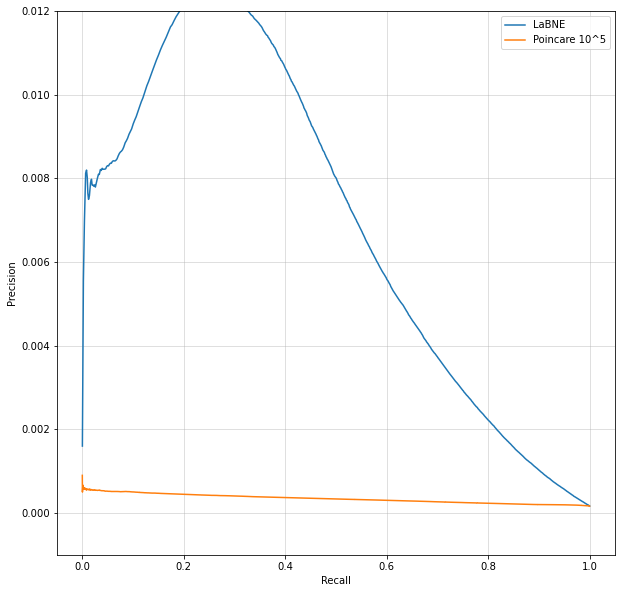

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(ASI_R_LaBNE_poincare, ASI_P_LaBNE_poincare, label='LaBNE')
ax.plot(ASI_R_Poincare, ASI_P_Poincare, label='Poincare 10^5')
# ax.plot(ASI_R_Poincare_radial_ordering, ASI_P_Poincare_radial_ordering, label='Poincare 10^5 radial ordering')
# #ax.plot(ASI_R_Poincare_, ASI_P_Poincare_, label='Poincare 10^6')
# #ax.plot(ASI_R_Poincare_radial_ordering_, ASI_P_Poincare_radial_ordering_, label='Poincare 10^6 radial ordering')
# ax.plot(ASI_R_Poincare_3dim, ASI_P_Poincare_3dim, label='Poincare 10^6 3dim')
# ax.plot(ASI_R_Poincare_radial_ordering_3dim, ASI_P_Poincare_radial_ordering_3dim, label='Poincare 10^6 3dim radial ordering')
# ax.plot(ASI_R_Poincare_10dim, ASI_P_Poincare_10dim, label='Poincare 10^6 10dim')
# ax.plot(ASI_R_Poincare_radial_ordering_10dim, ASI_P_Poincare_radial_ordering_10dim, label='Poincare 10^6 10dim radial ordering')
# ax.plot(ASI_R_Poincare_09, ASI_P_Poincare_09, label='ASI Poincare 09')

ax.legend()
ax.set_ylim(-0.001, 0.012)